In [1]:
import yaml
import torch
import torch.nn.functional as F
import pandas as pd
from gme_inference import GmeQwen2VL
from IPython.display import Image, display

# Utility function to load configuration from a YAML file
def load_config(config_file="config.yaml"):
    with open(config_file, "r") as f:
        return yaml.safe_load(f)

# Load configuration
config = load_config()

# Extract configuration parameters
gme_path = config.get("gme_path")
device = config.get("device", "cpu")

gme = GmeQwen2VL(gme_path, device=device)
gme.base.model = gme.base.model.float()  # Convert model parameters to float32


def find_top_k_similar_text(
    text_embedding, 
    embeddings_dict_path, 
    k=5,
    similarity_type="dot"   # new parameter
):
    """
    Loads image embeddings from a .pt file, computes similarity (cosine or dot)
    to `text_embedding`, and returns the top-k most similar items.
    """
    # 1. Load the dictionary from the saved .pt file onto CPU
    embeddings_dict = torch.load(embeddings_dict_path, map_location="cpu")

    # 2. Convert text_embedding to float32 and move it to CPU
    text_embedding = text_embedding.to(torch.float32).cpu()

    similarities = []

    for file_path, img_embedding in embeddings_dict.items():
        # Ensure shape is [1, hidden_dim] or similar
        if len(img_embedding.shape) == 1:
            img_embedding = img_embedding.unsqueeze(0)

        img_embedding = img_embedding.to(torch.float32).cpu()

        # Compute similarity based on the selected type
        if similarity_type == "cosine":
            # Normalize both embeddings
            text_embedding_normalized = F.normalize(text_embedding, p=2, dim=-1)
            img_embedding_normalized = F.normalize(img_embedding, p=2, dim=-1)
            # Compute cosine similarity
            sim = torch.mm(text_embedding_normalized, img_embedding_normalized.transpose(0, 1))
            similarity_score = sim.item()

        elif similarity_type == "dot":
            # Direct dot product (no normalization)
            sim = torch.mm(text_embedding, img_embedding.transpose(0, 1))
            similarity_score = sim.item()

        else:
            raise ValueError(f"Unknown similarity type: {similarity_type}")

        similarities.append((file_path, similarity_score))

    # Sort by similarity descending and return top-k
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:k]


f:\github\bqb-server\gme_inference.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
d:\anaconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
d:\anaconda3\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/py

Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


encode:   0%|          | 0/1 [00:00<?, ?it/s]

,File Path,Similarity Score
0,奥特曼00113-好骚的气味捂住.gif,0.587230
1,奥特曼00144-奥特曼的蔑视.jpg,0.548431
2,奥特曼00269-作为一个奥特曼我完全看不起你.jpg,0.535727
3,奥特曼00165-你们是我带过最差的一届奥特曼.jpg,0.504868
4,奥特曼00278-奥特抬棺.jpg,0.499713


Showing top 5 images:
./bqb_preview/奥特曼00113-好骚的气味捂住.gif.png -> 0.5872


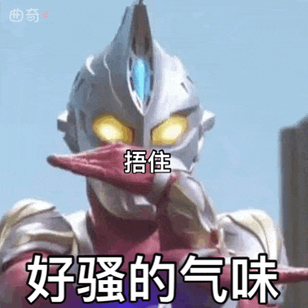

./bqb_preview/奥特曼00144-奥特曼的蔑视.jpg -> 0.5484


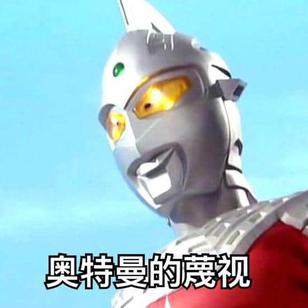

./bqb_preview/奥特曼00269-作为一个奥特曼我完全看不起你.jpg -> 0.5357


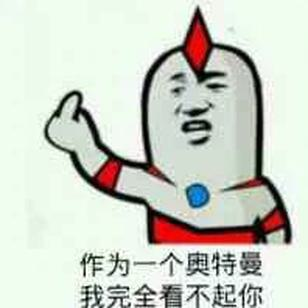

./bqb_preview/奥特曼00165-你们是我带过最差的一届奥特曼.jpg -> 0.5049


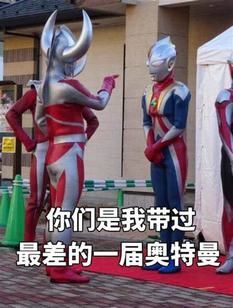

./bqb_preview/奥特曼00278-奥特抬棺.jpg -> 0.4997


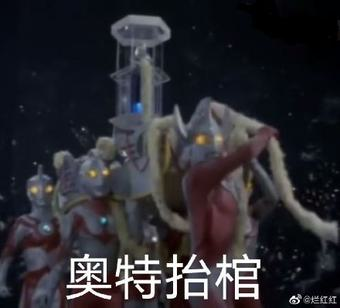

In [4]:
# Example usage:
e_text = gme.get_text_embeddings(texts=["given text: \"臭 奥特曼\""], instruction='Find a expressive image that matches the given text.')

embeddings_dict_path = r"./embedding_dicts/7b_embeddings_dict.pt"
embeddings_dict_path = r"./embedding_dicts/7b_fused_embeddings_dict.pt"
k = 5
top_k_results = find_top_k_similar_text(e_text, embeddings_dict_path, k=k, similarity_type= "cosine")

# Display the top-k results in a table
df_top_k = pd.DataFrame(top_k_results, columns=["File Path", "Similarity Score"])
display(df_top_k)

# Additionally, display the actual images in the notebook
print(f"Showing top {k} images:")
for file_name, similarity_score in top_k_results:
    file_path = "./bqb_preview/" + file_name
    if file_path[-3:] == "gif":
        file_path = file_path + ".png"
    print(f"{file_path} -> {similarity_score:.4f}")
    display(Image(filename=file_path))
